
# **PyTorch Cats vs Dogs - Feature Extraction**

---

 used a pretrained network as a feature extractor and then use those feautres as the input for our Logistic Regression Clasifier.
1. Load our pretrained VGG16 Model
2. Download our data and setup our transformations
3. Extract our Features using VGG16
4. Train a LR Classifier using those features
5. Run some inferences on our Test Data
---




## **1. Download Pre-trained Models (VGG16)**

In [2]:
import torch
import os
import tqdm
import torch.nn as nn
import pandas as pd
from PIL import Image
from torchsummary import summary
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.vgg16(pretrained=True)
model = model.to(device)

summary(model, input_size = (3,224,224))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

### **Remove the top Dense Fully Connected Layers**

In [3]:
# remove last fully-connected layer
new_classifier = nn.Sequential(*list(model.classifier.children())[:-7])
model.classifier = new_classifier

`python
Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)`

In [4]:
summary(model, input_size = (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

## **2. Download our data and setup our Transformers**

In [5]:
!wget https://moderncomputervision.s3.eu-west-2.amazonaws.com/dogs-vs-cats.zip
!unzip -q dogs-vs-cats.zip
!unzip -q train.zip
!unzip -q test1.zip

--2023-10-02 09:07:42--  https://moderncomputervision.s3.eu-west-2.amazonaws.com/dogs-vs-cats.zip
Resolving moderncomputervision.s3.eu-west-2.amazonaws.com (moderncomputervision.s3.eu-west-2.amazonaws.com)... 52.95.144.6, 3.5.244.11, 52.95.150.6, ...
Connecting to moderncomputervision.s3.eu-west-2.amazonaws.com (moderncomputervision.s3.eu-west-2.amazonaws.com)|52.95.144.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 851576689 (812M) [application/zip]
Saving to: ‘dogs-vs-cats.zip’

dogs-vs-cats.zip    100%[===================>] 812.13M  21.7MB/s    in 39s     

2023-10-02 09:08:21 (20.9 MB/s) - ‘dogs-vs-cats.zip’ saved [851576689/851576689]



In [6]:
# Set directory paths for our files
train_dir = './train'
test_dir = './test1'

# Get files in our directories
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

print(f'Number of images in {train_dir} is {len(train_files)}')
print(f'Number of images in {test_dir} is {len(test_files)}')

transformations = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor()])

class Dataset():
    def __init__(self, filelist, filepath, transform = None):
        self.filelist = filelist
        self.filepath = filepath
        self.transform = transform

    def __len__(self):
        return int(len(self.filelist))

    def __getitem__(self, index):
        imgpath = os.path.join(self.filepath, self.filelist[index])
        img = Image.open(imgpath)

        if "dog" in imgpath:
            label = 1
        else:
            label = 0

        if self.transform is not None:
            img = self.transform(img)

        return (img, label)

# Create our train and test dataset objects
train = Dataset(train_files, train_dir, transformations)
val = Dataset(test_files, test_dir, transformations)

# Create our dataloaders
train_dataset = torch.utils.data.DataLoader(dataset = train, batch_size = 32, shuffle=True)
val_dataset = torch.utils.data.DataLoader(dataset = val, batch_size = 32, shuffle=True)

Number of images in ./train is 25000
Number of images in ./test1 is 12500


## **3. Extract our Features using VGG16**

In [7]:
image_names = os.listdir("./train")
image_paths = ["./train/"+ x for x in image_names]

In [8]:
model.eval()
model = model.cuda()

with torch.no_grad():
    features = None
    image_labels = None

    # loop over each batch and pass our input tensors to hte model
    for data, label in tqdm.tqdm(train_dataset):
        x = data.cuda()
        output = model(x)

        if features is not None:
            # Concatenates the given sequence of tensors in the given dimension.
            # cat needs at least two tensors so we only start to cat after the first loop
            features = torch.cat((features, output), 0)
            image_labels = torch.cat((image_labels, label), 0)
        else:
            features = output
            image_labels = label

    # reshape our tensor to 25000 x 25088
    features = features.view(features.size(0), -1)


100%|██████████| 782/782 [02:14<00:00,  5.80it/s]


In [9]:
# Check that we have features for all 25000 images
features.size(0)

25000

In [10]:
# Check that we have labels for all 25000 images
image_labels.shape

torch.Size([25000])

In [11]:
# Check the shape to ensure our features are a flattened 512*7*7 array
features.shape

torch.Size([25000, 25088])

## **4. Train a LR Classifier using those features**

In [12]:
# Convert our tensors to numpy arrays
features_np = features.cpu().numpy()
image_labels_np = image_labels.cpu().numpy()

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Split our model into a test and training dataset to train our LR classifier
X_train, X_test, y_train, y_test = train_test_split(features_np, image_labels_np, test_size=0.2, random_state = 7)

glm = LogisticRegression(C=0.1)
glm.fit(X_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.1)

In [14]:
# Get Accruacy
accuracy = glm.score(X_test, y_test)
print(f'Accuracy on validation set using Logistic Regression: {accuracy*100}%')

Accuracy on validation set using Logistic Regression: 96.46000000000001%


## **5. Run some inferences on our Test Data**

In [15]:
image_names_test = os.listdir("./test1")
image_paths_test = ["./test1/"+ x for x in image_names_test]

In [16]:
from torch.autograd import Variable

imsize = 224

loader = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])

def image_loader(loader, image_name):
    image = Image.open(image_name)
    image = loader(image).float()
    image = torch.tensor(image, requires_grad=True)
    image = image.unsqueeze(0)
    return image

In [17]:
import random

test_sample = random.sample(image_paths_test, 12)
model.eval()

def test_img():
    result_lst = []
    for path in test_sample:
      image = image_loader(loader, path)
      output = model(image.to(device))
      output = output.cpu().detach().numpy()
      result = glm.predict(output)
      result = 'dog' if float(result) >0.5 else 'cat'
      result_lst.append(result)
    return result_lst

In [18]:
# get test predictions from all models
pred_results = test_img()
pred_results

<ipython-input-16-4b6569469c62>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, requires_grad=True)
<ipython-input-16-4b6569469c62>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, requires_grad=True)
<ipython-input-16-4b6569469c62>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, requires_grad=True)
<ipython-input-16-4b6569469c62>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.c

['cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'dog',
 'cat']

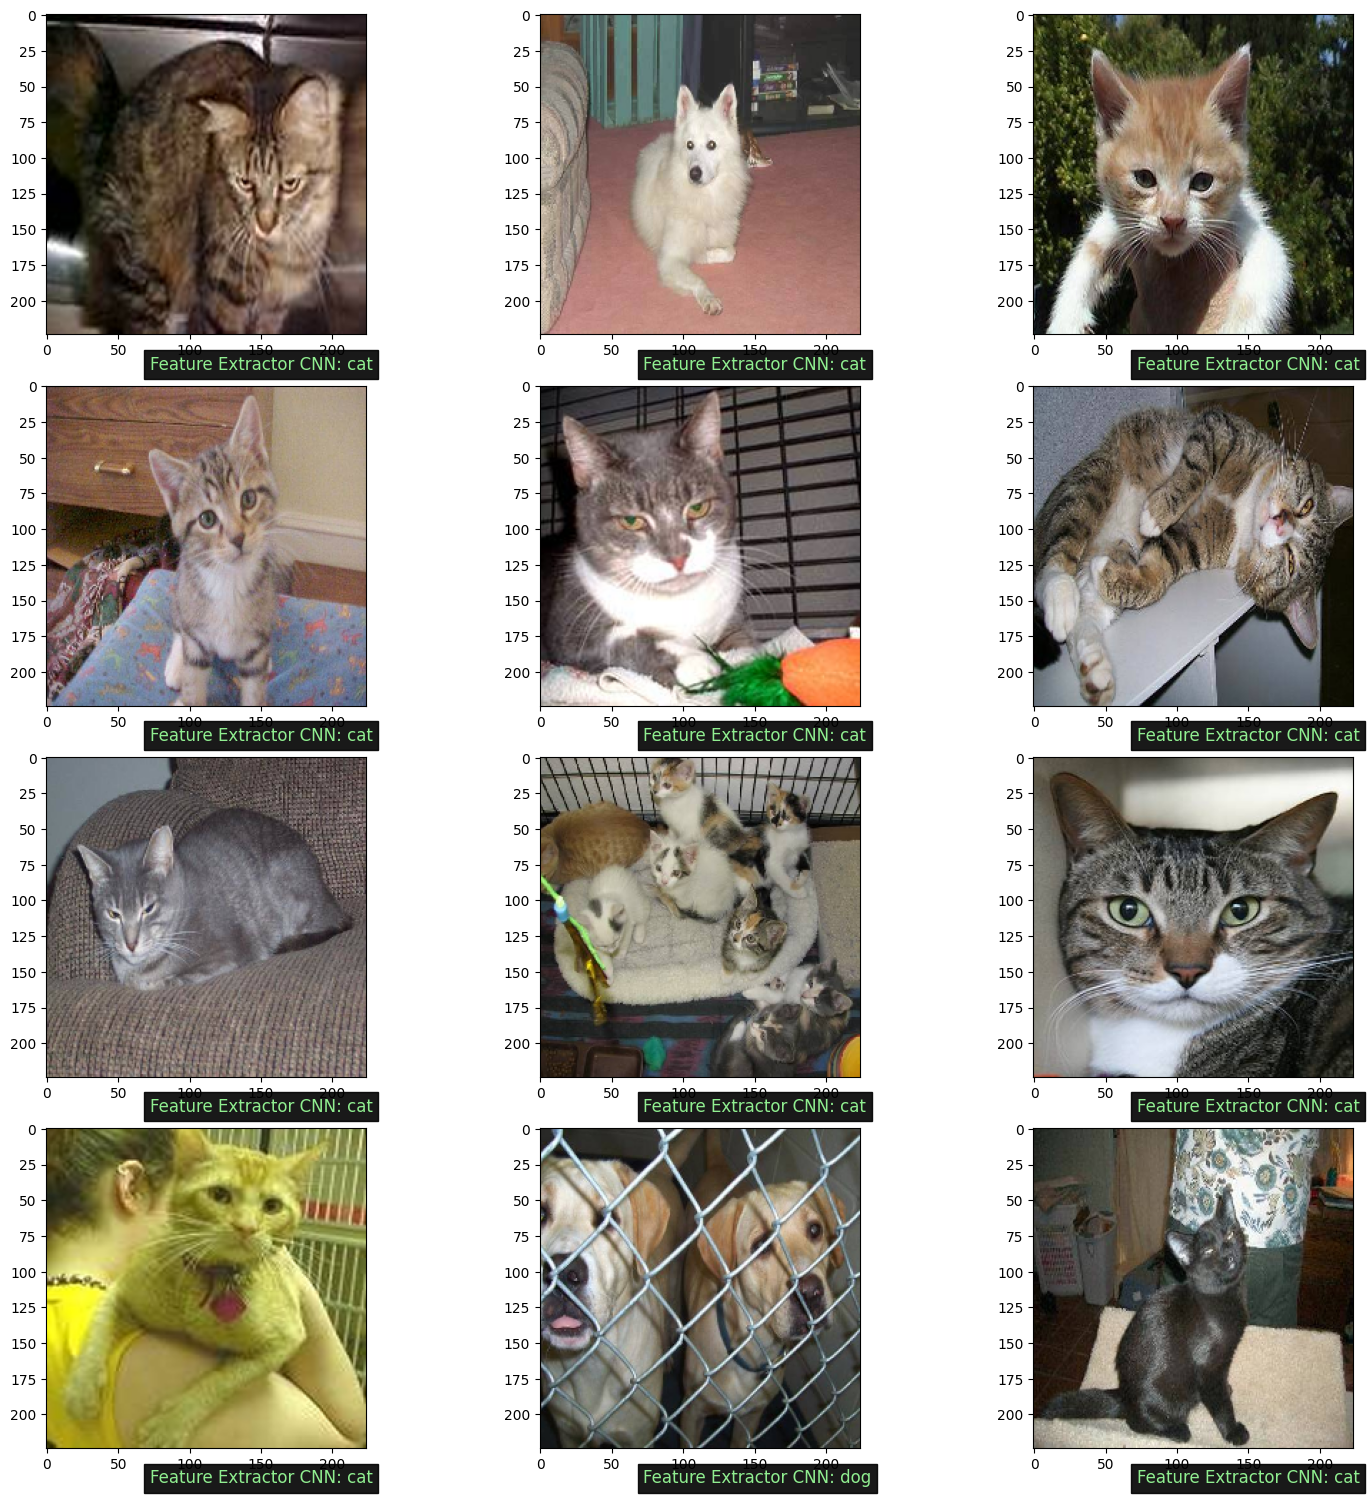

In [19]:
import cv2

plt.figure(figsize=(15, 15))

for i in range(0, 12):
    plt.subplot(4, 3, i+1)
    result = pred_results[i]
    img = test_sample[i]
    image = cv2.imread(img)
    image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_CUBIC)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.text(72, 248, f'Feature Extractor CNN: {result}', color='lightgreen',fontsize= 12, bbox=dict(facecolor='black', alpha=0.9))
    plt.imshow(image)

plt.tight_layout()
plt.show()